In [1]:
import sys
sys.path.append("/Users/gregmartinez/.local/share/virtualenvs/mtg_scraper-N8QFuhGA/lib/python3.8/site-packages/")

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [4]:
# Load data
FLAT_FILE_DIR = "../flat_files/"

full_table = pd.read_csv(FLAT_FILE_DIR + "full_table.csv", parse_dates=["date"])
event_table = pd.read_csv(FLAT_FILE_DIR + "event_table.csv", parse_dates=["date"])
deck_list_table = pd.read_csv(FLAT_FILE_DIR + "deck_list_table.csv")
pilot_table = pd.read_csv(FLAT_FILE_DIR + "pilot_table.csv")
deck_table = pd.read_csv(FLAT_FILE_DIR + "deck_table.csv")
card_table = pd.read_csv(FLAT_FILE_DIR + "card_table.csv")

deck_table["rank"] = pd.to_numeric(deck_table["rank"])

# Goal

Use linear regression to predict the rank a deck would earn in a tournament.

### Data

While there are several differnt tables to work with, the main deck to focus on is the deck_table. This has all of the relevant features, plus the target labels (rank). Another table that will be used is the full_table, which has more detail on specific cards in each deck.

### Features

Some features of interest are the colors in the deck, the archetype of the deck, and the ratio of the different types of cards (permanents vs instants/sorceries, or creatures vs non-creatures).

### Thresholds

For any statistical test, the significance threshold will be taken to be the standard 0.05.
The classification threshold for linear regression models will be 0.5.

### Experiments/Process

### Results

In [7]:
# One-hot encoding categorical data in deck_table
# Start with "Category"
arch_dummy = pd.get_dummies(deck_table, columns=["category"], prefix=["cat"])
arch_dummy

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,cat_4-color,cat_5-color,cat_abzan,cat_azorius,cat_bant,cat_boros,cat_colorless,cat_dimir,cat_esper,cat_golgari,cat_grixis,cat_gruul,cat_izzet,cat_jeskai,cat_jund,cat_mardu,cat_mono black,cat_mono blue,cat_mono green,cat_mono red,cat_mono white,cat_naya,cat_orzhov,cat_rakdos,cat_selesnya,cat_simic,cat_sultai,cat_temur
0,1,1,3,?e=27938&d=421597&f=ST,Gruul Aggro,1,aggro,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,4,?e=27938&d=421598&f=ST,UW Control,2,control,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,2,5,?e=27939&d=421599&f=ST,Red Deck Wins,1,aggro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,4,3,6,?e=27940&d=421600&f=ST,Rakdos Aggro,1,aggro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5,4,7,?e=27925&d=421512&f=ST,Gruul Aggro,1,aggro,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,4478,829,805,?e=29948&d=434792&f=ST,Temur Aggro Adventure,5,adventure,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4478,4479,830,2394,?e=29959&d=434835&f=ST,Red Deck Wins,1,aggro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4479,4480,830,2395,?e=29959&d=434836&f=ST,Red Deck Wins,2,aggro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4480,4481,830,2396,?e=29959&d=434837&f=ST,Red Deck Wins,3,aggro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [7]:
# Get One-hot encoding for "Category"
cat_dummy = pd.get_dummies(deck_table, columns=["category"], prefix="cat")
cat_dummy

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,cat_4-color,cat_5-color,cat_abzan,cat_azorius,cat_bant,cat_boros,cat_colorless,cat_dimir,cat_esper,cat_golgari,cat_grixis,cat_gruul,cat_izzet,cat_jeskai,cat_jund,cat_mardu,cat_mono black,cat_mono blue,cat_mono green,cat_mono red,cat_mono white,cat_naya,cat_orzhov,cat_rakdos,cat_selesnya,cat_simic,cat_sultai,cat_temur
0,1,1,3,?e=27938&d=421597&f=ST,Gruul Aggro,1,aggro,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,4,?e=27938&d=421598&f=ST,UW Control,2,control,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,2,5,?e=27939&d=421599&f=ST,Red Deck Wins,1,aggro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,4,3,6,?e=27940&d=421600&f=ST,Rakdos Aggro,1,aggro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5,4,7,?e=27925&d=421512&f=ST,Gruul Aggro,1,aggro,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,3635,681,2058,?e=29485&d=431577&f=ST,Naya Aggro,5,aggro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3635,3636,682,2059,?e=29483&d=431566&f=ST,Gruul Aggro,1,aggro,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3636,3637,682,1655,?e=29483&d=431567&f=ST,Sultai Yorion Ultimatum,2,ramp,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3637,3638,683,203,?e=29484&d=431568&f=ST,Weenie White,1,aggro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [8]:
# List of dummy columns
arch_cols = list(
    filter(
        lambda x: x.startswith("arch_"),
        arch_dummy.columns
    )
)
cat_cols = list(
    filter(
        lambda x: x.startswith("cat_"),
        cat_dummy.columns
    )
)

In [16]:
x1, x2, y1, y2 = train_test_split(arch_dummy["rank"], np.array(arch_dummy[["arch_aggro", "arch_control"]]))

In [17]:
y1

array([[0, 1],
       [0, 1],
       [0, 0],
       ...,
       [0, 0],
       [1, 0],
       [0, 1]], dtype=uint8)

In [18]:
arch_train, arch_test, rank_train, rank_test = (
    train_test_split(
        np.array(arch_dummy[["arch_aggro", "arch_control", "arch_mill", "arch_ramp"]]),
        arch_dummy["rank"]
    )
)

In [19]:
arch_train.shape

(2729, 4)

In [20]:
rank_train.shape

(2729,)

In [21]:
# Create models

arch_model = LinearRegression(normalize=True)
arch_model.fit(arch_train, rank_train)

LinearRegression(normalize=True)

In [22]:
arch_model.score(arch_test, rank_test)

-0.003372038854195347

In [30]:
len(arch_test)

910

In [23]:
arch_model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': True,
 'positive': False}

In [36]:
arch_model.coef_

array([0.1758524 , 0.22365191, 0.40527731, 0.36757548])

In [37]:
arch_model.intercept_

2.782894736842105

In [29]:
(arch_model.predict(arch_test))

array([2.95874714, 3.00654664, 3.00654664, 3.18817204, 2.95874714,
       2.95874714, 3.15047022, 2.95874714, 3.00654664, 2.95874714,
       2.95874714, 2.78289474, 2.95874714, 3.18817204, 3.15047022,
       2.95874714, 2.95874714, 2.95874714, 2.95874714, 2.95874714,
       2.95874714, 2.95874714, 2.95874714, 3.15047022, 2.95874714,
       2.95874714, 2.95874714, 2.95874714, 3.18817204, 2.95874714,
       3.00654664, 2.95874714, 2.95874714, 3.15047022, 2.95874714,
       2.95874714, 3.00654664, 2.95874714, 3.15047022, 2.78289474,
       3.00654664, 2.95874714, 3.18817204, 3.00654664, 2.95874714,
       2.95874714, 2.95874714, 3.18817204, 2.95874714, 3.15047022,
       2.95874714, 2.95874714, 2.95874714, 2.78289474, 2.95874714,
       2.95874714, 2.95874714, 2.95874714, 3.15047022, 3.00654664,
       2.95874714, 3.00654664, 2.95874714, 2.95874714, 2.95874714,
       2.95874714, 2.78289474, 2.78289474, 2.95874714, 2.95874714,
       3.00654664, 3.15047022, 2.78289474, 3.15047022, 3.00654

In [25]:
arch_dummy[["rank", "arch_control"]]["rank"].mean()

2.974993129980764

OHE gave some funky results, so I will try a different approach

In [71]:
arch_dummy = deck_table[["rank", "archetype"]].copy()
arch_dummy["is_first"] = (
    arch_dummy
    .apply(lambda x: 1 if x["rank"] == 1 else 0, axis=1)
)

In [72]:
arch_count = arch_dummy["archetype"].value_counts()

In [73]:
arch_count

aggro          1738
control         821
ramp            429
mill            243
adventure       125
rogue            92
cycling          79
jund             40
winota           22
midrange         18
food             13
sacrifce          4
flash             3
golgari           2
dragons           2
reclamation       2
mutate            2
kicker            2
stompy            1
gyruda            1
Name: archetype, dtype: int64

In [74]:
mask = arch_dummy["archetype"].isin(arch_count[arch_count < 12].index)
arch_dummy["archetype"][mask] = "other"

<ipython-input-74-b72ced957838>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arch_dummy["archetype"][mask] = "other"


In [75]:
arch_dummy["archetype"].value_counts()

aggro        1738
control       821
ramp          429
mill          243
adventure     125
rogue          92
cycling        79
jund           40
winota         22
other          19
midrange       18
food           13
Name: archetype, dtype: int64

In [76]:
arch_dummy = pd.get_dummies(arch_dummy, columns=["archetype"], prefix="arch")

In [77]:
arch_dummy

,rank,is_first,arch_adventure,arch_aggro,arch_control,arch_cycling,arch_food,arch_jund,arch_midrange,arch_mill,arch_other,arch_ramp,arch_rogue,arch_winota
0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,5,0,0,1,0,0,0,0,0,0,0,0,0,0
3635,1,1,0,1,0,0,0,0,0,0,0,0,0,0
3636,2,0,0,0,0,0,0,0,0,0,0,1,0,0
3637,1,1,0,1,0,0,0,0,0,0,0,0,0,0


In [126]:
rank_train, rank_test, arch_train, arch_test = (
    train_test_split(
        arch_dummy[["arch_aggro"]],
        arch_dummy[["is_first"]],
    )
)


In [127]:
rank_train

,arch_aggro
1574,0
1944,1
3431,1
529,0
2102,1
...,...
231,0
778,0
1932,1
418,1


In [128]:
arch_model = LinearRegression()
arch_model.fit(rank_train, arch_train)

LinearRegression()

In [129]:
arch_model.coef_

array([[0.02183873]])

In [130]:
arch_model.score(rank_test, arch_test)

0.0024619096110424232

In [133]:
arch_model.predict(pd.DataFrame({"arch_aggro": [1, 1, 0]}))

array([[0.27756939],
       [0.27756939],
       [0.25573066]])

## Trying a different tactic: Get "dummies" by color

In [9]:
white_categories = [
    "mono white",
    "azorius",
    "borors",
    "selesnya",
    "orzhov",
    "abzan",
    "jeskai",
    "mardu",
    "bant",
    "naya",
    "esper"
]
red_categories = [
    "mono red",
    "boros",
    "rakdos",
    "gruul",
    "izzet",
    "naya",
    "grixis",
    "jund",
    "temur",
    "jeskai",
    "mardu"
]
blue_categories = [
    "mono blue",
    "azorius",
    "izzet",
    "simic",
    "dimir",
    "bant",
    "esper",
    "grixis",
    "temur",
    "sultai",
    "jeskai"
]
black_categories = [
    "mono black",
    "orzhov",
    "rakdos",
    "dimir",
    "golgari",
    "grixis",
    "esper",
    "jund",
    "abzan",
    "sultai",
    "mardu"
]
green_categories = [
    "mono green",
    "gruul",
    "golgari",
    "selesnya",
    "simic",
    "naya",
    "bant",
    "jund",
    "temur",
    "sultai",
    "abzan"
]

In [12]:
deck_table["W"] = deck_table["category"].apply(lambda x: 1 if x in white_categories else 0)
deck_table["U"] = deck_table["category"].apply(lambda x: 1 if x in blue_categories else 0)
deck_table["B"] = deck_table["category"].apply(lambda x: 1 if x in black_categories else 0)
deck_table["R"] = deck_table["category"].apply(lambda x: 1 if x in red_categories else 0)
deck_table["G"] = deck_table["category"].apply(lambda x: 1 if x in green_categories else 0)

In [14]:
deck_table["rank_label"] = deck_table["rank"].apply(lambda x: 1 if x == 1 else 0)

In [104]:
deck_table

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category,W,U,B,R,G,rank_label
0,1,1,3,?e=27938&d=421597&f=ST,Gruul Aggro,1,aggro,gruul,0,0,0,1,1,1
1,2,1,4,?e=27938&d=421598&f=ST,UW Control,2,control,azorius,1,1,0,0,0,0
2,3,2,5,?e=27939&d=421599&f=ST,Red Deck Wins,1,aggro,mono red,0,0,0,1,0,1
3,4,3,6,?e=27940&d=421600&f=ST,Rakdos Aggro,1,aggro,rakdos,0,0,1,1,0,1
4,5,4,7,?e=27925&d=421512&f=ST,Gruul Aggro,1,aggro,gruul,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943,4944,922,2564,?e=30435&d=437663&f=ST,Gruul Adventure Aggro,5,adventure,gruul,0,0,0,1,1,0
4944,4945,922,2565,?e=30435&d=437662&f=ST,Temur Aggro Adventure,5,adventure,temur,0,1,0,1,1,0
4945,4946,922,2566,?e=30435&d=437665&f=ST,Temur Value,5,NaN,temur,0,1,0,1,1,0
4946,4947,923,2567,?e=30427&d=437625&f=ST,Naya Aggro,1,aggro,naya,1,0,0,1,1,1


In [179]:
deck_table["B"].value_counts()

0    3092
1    1856
Name: B, dtype: int64

In [128]:
train_cats, test_cats, train_ranks, test_ranks = \
    train_test_split(deck_table[["W", "U", "B", "R", "G"]], deck_table["rank_label"])

In [129]:
category_model = LogisticRegression()
category_model.fit(train_cats, train_ranks)

LogisticRegression()

In [130]:
category_model.coef_

array([[ 0.17116171, -0.01768777, -0.07004534,  0.00370885, -0.02966188]])

In [131]:
category_model.score(test_cats, test_ranks)

0.7526273241713823

In [132]:
test_cats

,W,U,B,R,G
2421,0,0,0,0,1
2485,0,1,1,0,0
1549,0,0,1,1,0
930,0,1,1,0,1
4851,1,1,0,1,0
...,...,...,...,...,...
1004,0,0,1,1,1
3419,0,0,0,1,0
1816,0,0,0,1,1
4471,1,0,0,1,1


In [133]:
train_cats

,W,U,B,R,G
4085,0,1,0,1,1
3146,0,1,1,1,0
4653,0,0,1,0,0
2514,0,0,0,1,1
230,1,1,0,0,0
...,...,...,...,...,...
2349,0,0,1,0,1
3326,1,0,0,1,1
168,0,1,1,0,0
1715,0,1,0,1,1


In [134]:
train_ranks

4085    0
3146    0
4653    1
2514    0
230     0
       ..
2349    0
3326    0
168     0
1715    0
626     0
Name: rank_label, Length: 3711, dtype: int64

In [138]:
category_model.predict_proba([[0, 0, 1, 1, 0]])[0][1]

0.2502898690276886

In [142]:
np.array(train_cats.iloc[1])

array([0, 1, 1, 1, 0])

In [166]:
deck_table_labels = deck_table[["W", "U", "B", "R", "G"]]

In [167]:
category_model.predict_proba([deck_table_labels.iloc[2].tolist()])

array([[0.73633806, 0.26366194]])

In [170]:
predicted_wins = []
for i in range(len(deck_table_labels)):
    next_row = deck_table_labels.iloc[i].tolist()
    predicted_wins.append(category_model.predict_proba([next_row])[0][0])

In [161]:
len(predicted_wins)

4948

In [162]:
len(deck_table["rank_label"])

4948

In [182]:
min(predicted_wins)

0.7025705387047945

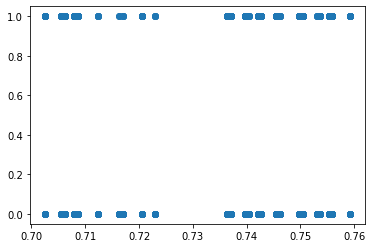

In [171]:
plt.scatter(predicted_wins, deck_table["rank_label"])

### This may be a lost cause:

Third, logistic regression requires there to be little or no multicollinearity among the independent variables.  This means that the independent variables should not be too highly correlated with each other.

It could be that some colors are highly correlated to other colors...